In [1]:
from underlying import Underlying
from option import Option, Vanilla
from trader import Trader

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
mu = 0.06
sigma =  0.3
r = 0.05
T = 1
X0 = 100
repeat = 1000

## Full hedging - Vanilla Call

In [3]:
K = 80

In [4]:
underlying = Underlying(mu, sigma, r, 250)

In [5]:
_, reality = underlying.simulate_P(repeat, T)

In [6]:
vanilla_call = Vanilla(underlying, K, T, True)

In [7]:
BS_price_call = vanilla_call.get_price(X0, 0)
BS_price_call

26.462085709671783

In [8]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_call)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.16it/s]


(0.0, 250.0)

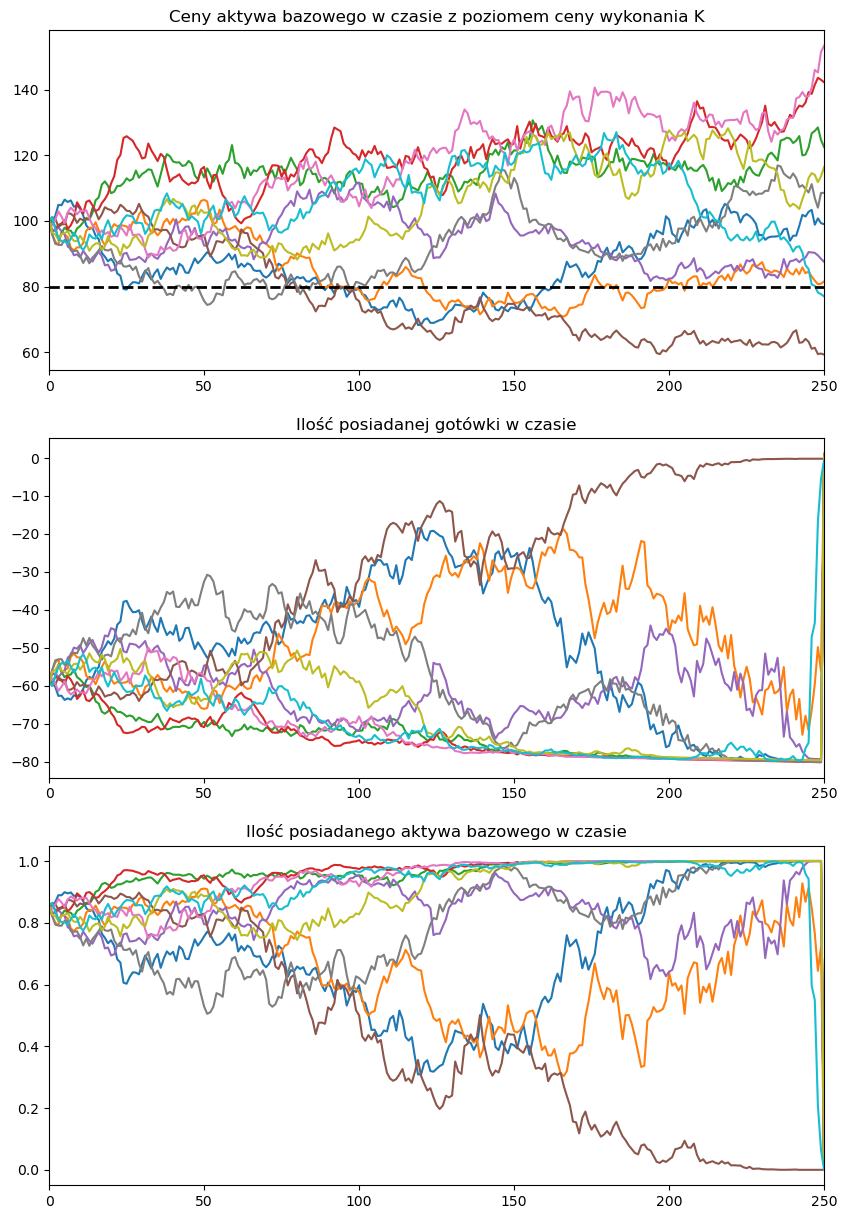

In [9]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,250])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,250])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,250])

Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = 0.007, std = 0.433')

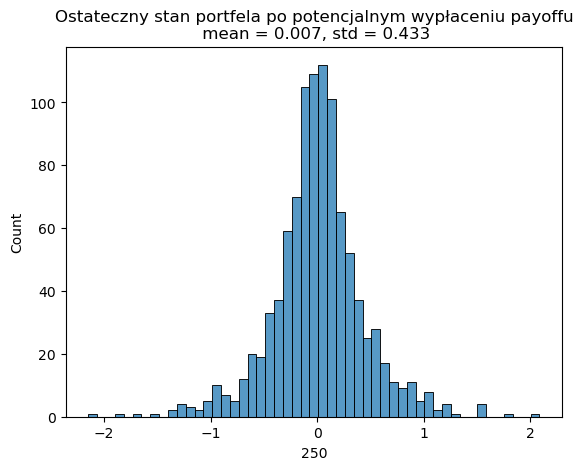

In [10]:
sb.histplot(money_time_call.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

## Full hedging - Vanilla Put

In [8]:
K = 120

In [9]:
underlying = Underlying(mu, sigma, r, 250)

In [10]:
_, reality = underlying.simulate_P(repeat, T)

In [11]:
vanilla_put = Vanilla(underlying, K, T, False)

In [12]:
BS_price_put = vanilla_put.get_price(X0, 0)
BS_price_put

21.05152849102445

In [16]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_put)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta

100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.39it/s]


(0.0, 250.0)

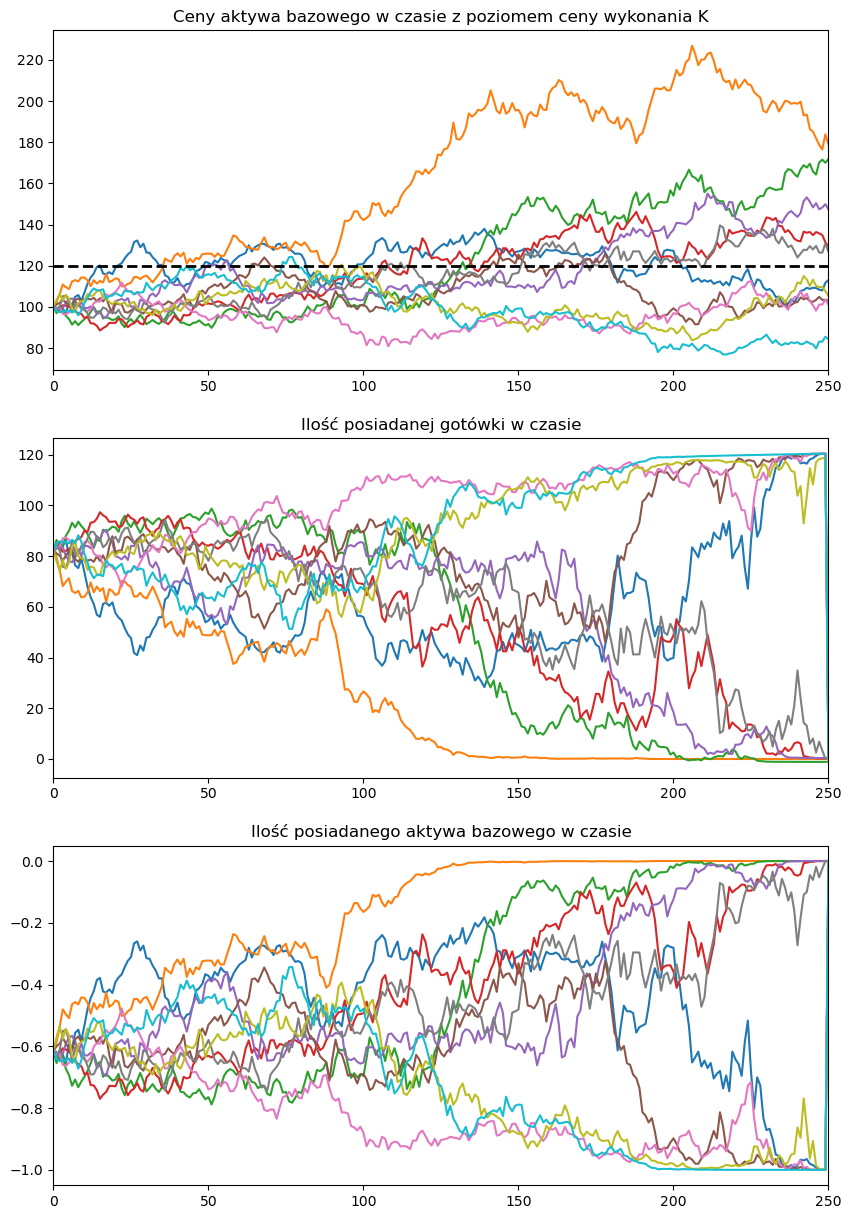

In [17]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,250])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,250])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,250])

Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = 0.013, std = 0.718')

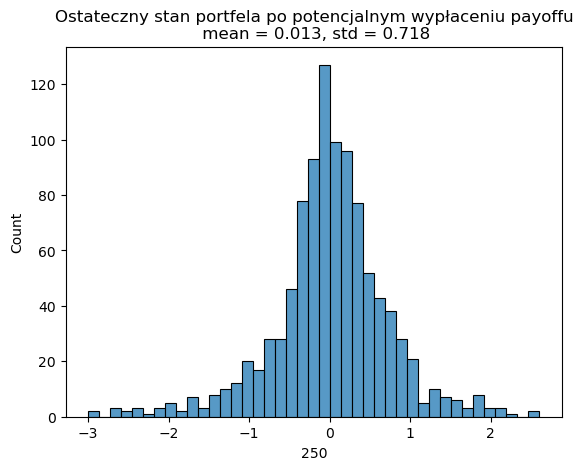

In [18]:
sb.histplot(money_time_put.iloc[:,-1]).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

## Quantile hedging with half of required initial capital- Vanilla Call

In [19]:
K = 80

In [20]:
underlying = Underlying(mu, sigma, r, 250)

In [21]:
_, reality = underlying.simulate_P(repeat, T)

In [22]:
V0 = BS_price_call / 2

In [23]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, success_prob = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {success_prob}')

100%|███████████████████████████████████████| 1000/1000 [03:51<00:00,  4.32it/s]

Success probability with initial capital=13.23 is: 0.81


(0.0, 250.0)

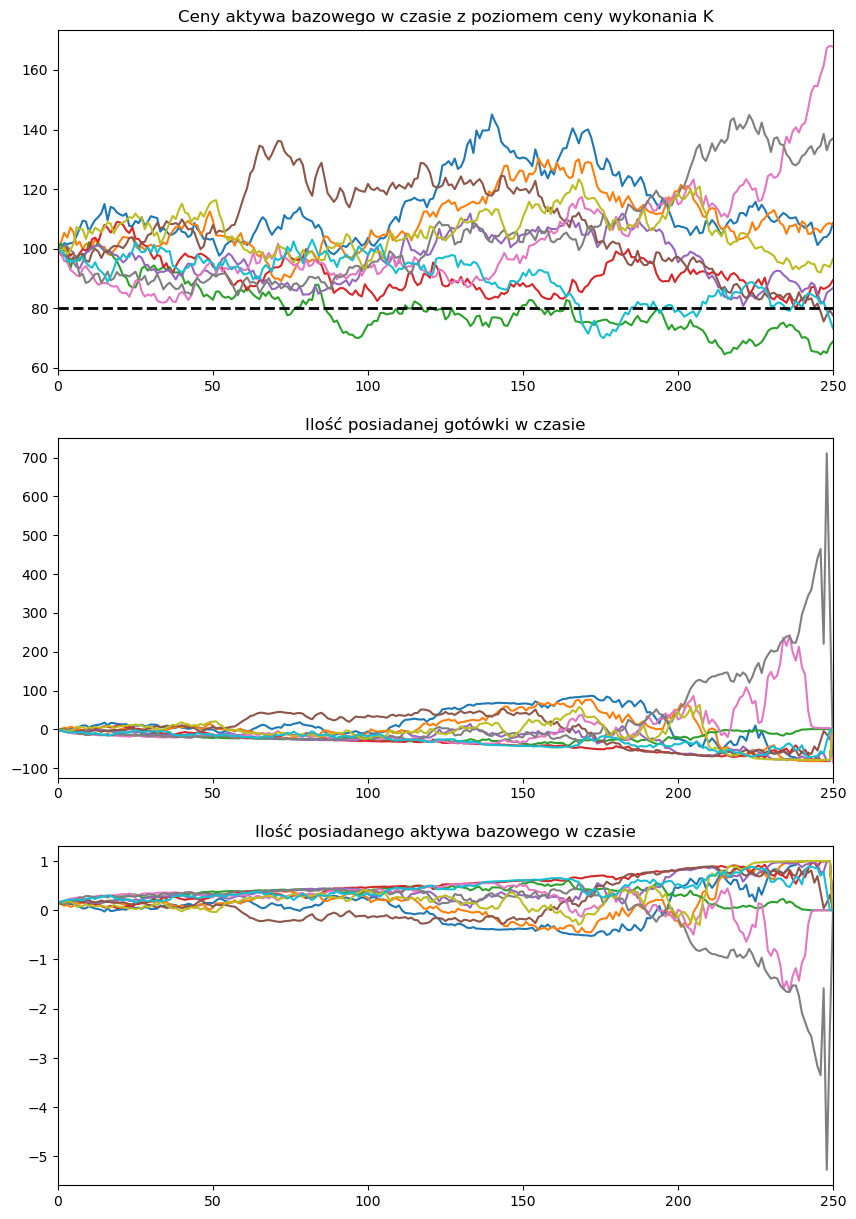

In [24]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,250])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,250])
(delta_time_call.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,250])

Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = -14.849, std = 31.216')

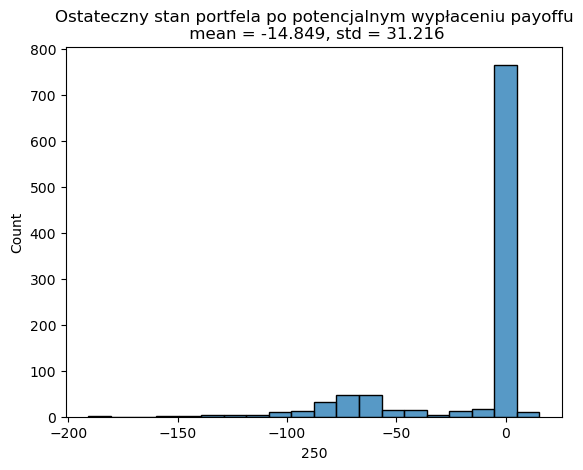

In [25]:
sb.histplot(money_time_call.iloc[:,-1], bins = 20).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_call.iloc[:,-1].mean():.3f}, std = {money_time_call.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

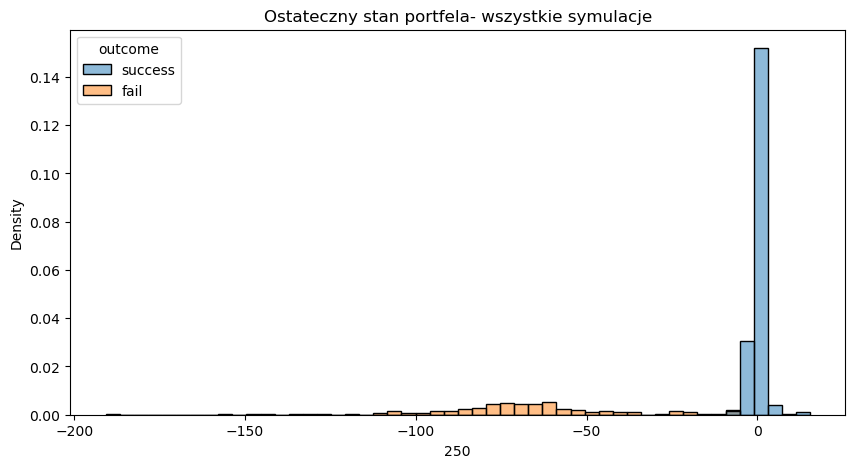

In [39]:
money_time_call_outcome = money_time_call.copy()
money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.5 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_call_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_call_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [40]:
money_time_call_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                          \
         count       mean        std         min        25%        50%   
outcome                                                                  
fail     218.0 -68.115523  28.769217 -190.829949 -81.329640 -68.800707   
success  782.0   0.000444   1.915591   -6.388383  -0.680086  -0.018781   

                               
               75%        max  
outcome                        
fail    -56.644098  -7.176249  
success   0.663960  15.424794

Text(0.5, 1.0, 'Ostateczny payoff opcji- wszystkie symulacje')

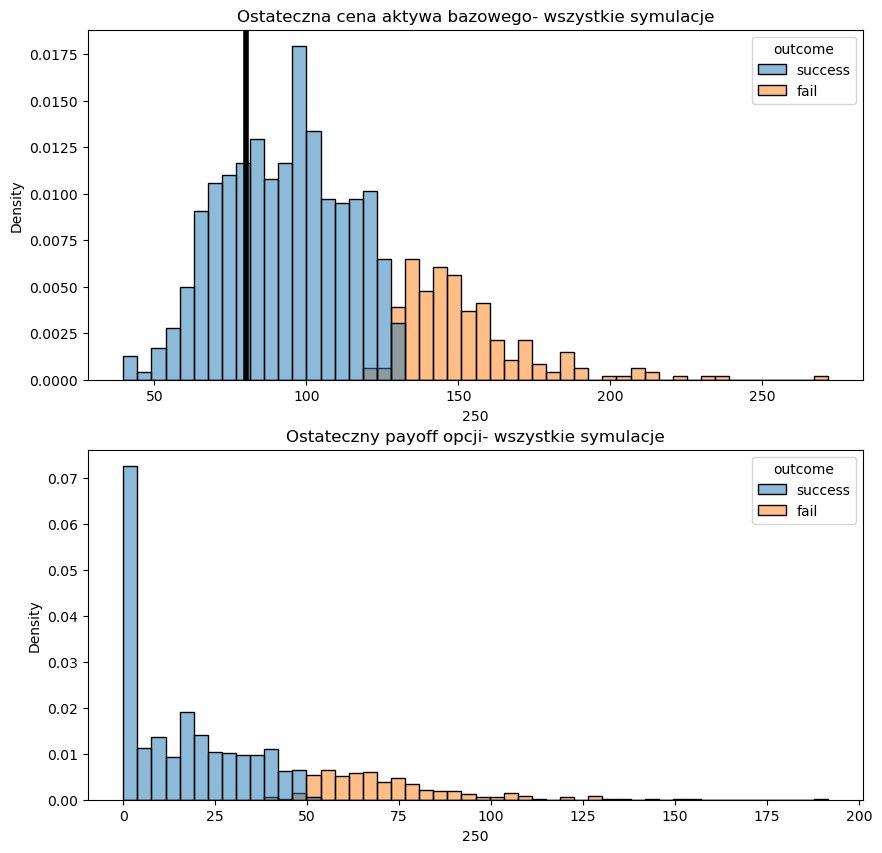

In [41]:
fig, axs = plt.subplots(2,1, figsize = (10, 10))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.histplot(ax = axs[1], x = np.maximum((X0*reality)[underlying.values_per_year * T] - K,0), hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji- wszystkie symulacje')

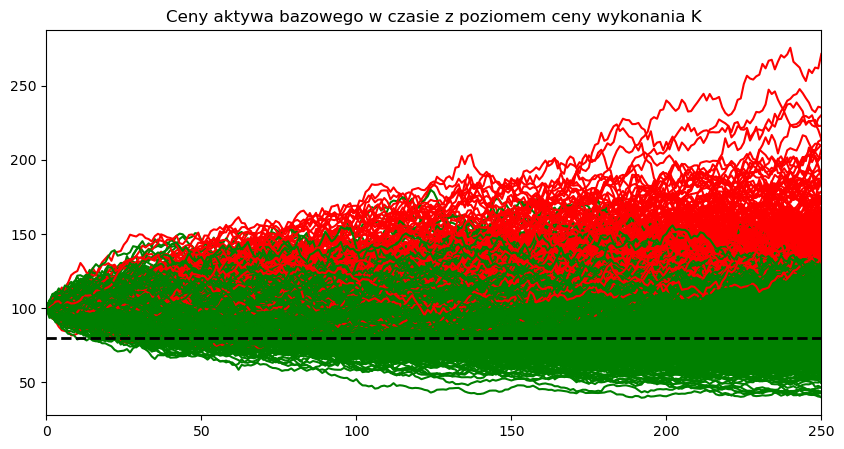

In [42]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, legend = False, color = money_time_call_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,250])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Quantile hedging with half of required initial capital- Vanilla Put

In [62]:
K = 120

In [63]:
underlying = Underlying(mu, sigma, r, 250)

In [64]:
_, reality = underlying.simulate_P(repeat, T)

In [65]:
V0 = BS_price_put / 2

In [66]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = V0)
    money, delta, success_prob = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta
print(f'Success probability with initial capital={V0:.2f} is: {success_prob}')

100%|███████████████████████████████████████| 1000/1000 [03:45<00:00,  4.44it/s]

Success probability with initial capital=10.53 is: 0.7927


(0.0, 250.0)

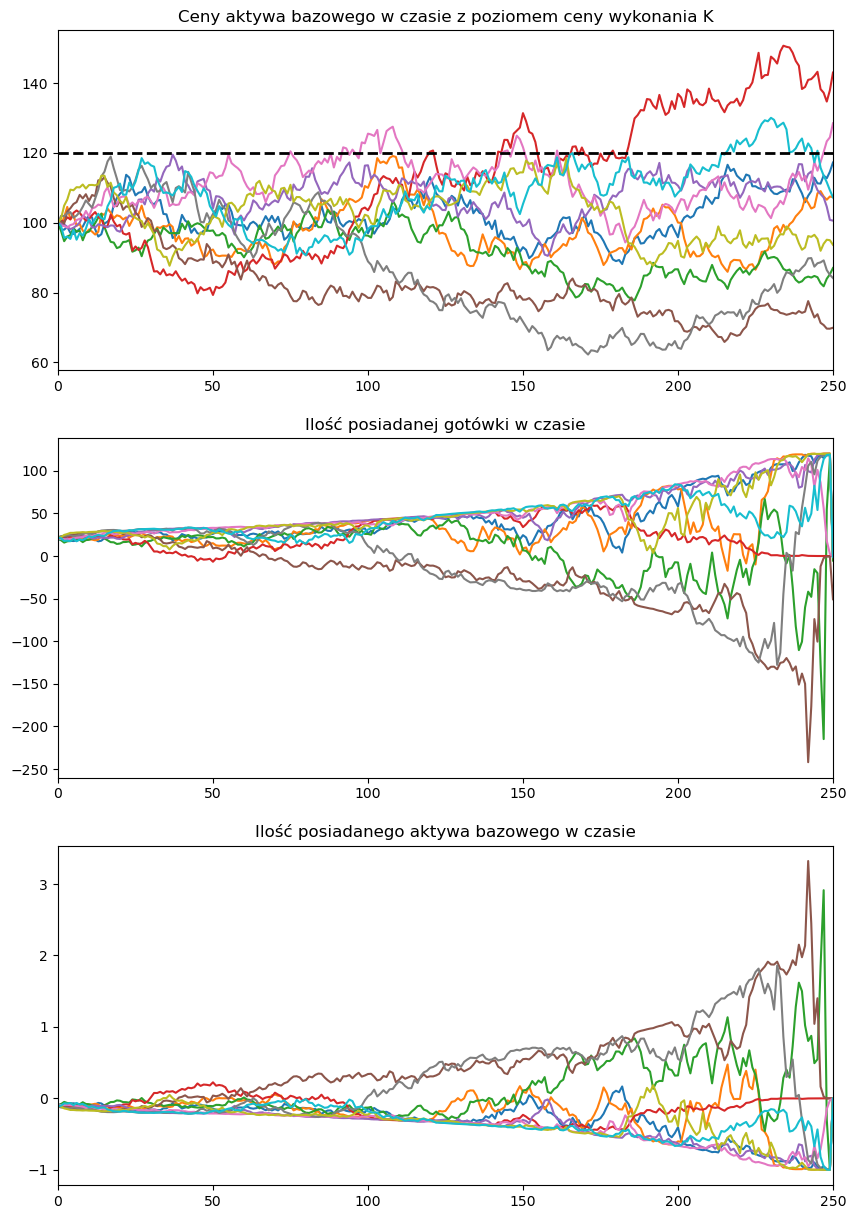

In [67]:
fig, axs = plt.subplots(3,1, figsize = (10, 15))
(X0*reality.iloc[:10,:]).T.plot.line(legend = False, ax = axs[0], title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs[0].set_xlim([0,250])
axs[0].axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)
(money_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[1], title = 'Ilość posiadanej gotówki w czasie')
axs[1].set_xlim([0,250])
(delta_time_put.iloc[:10,:]).T.plot(legend = False, ax = axs[2], title = 'Ilość posiadanego aktywa bazowego w czasie')
axs[2].set_xlim([0,250])

Text(0.5, 1.0, 'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = -10.923, std = 21.404')

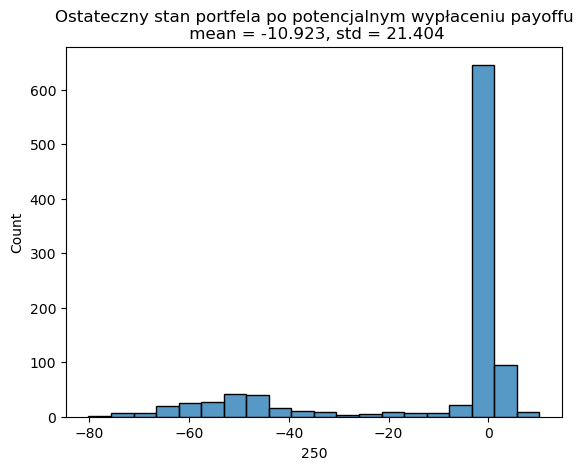

In [68]:
sb.histplot(money_time_put.iloc[:,-1], bins = 20).set_title(f'Ostateczny stan portfela po potencjalnym wypłaceniu payoffu\n mean = {money_time_put.iloc[:,-1].mean():.3f}, std = {money_time_put.iloc[:,-1].std():.3f}')

Text(0.5, 1.0, 'Ostateczny stan portfela- wszystkie symulacje')

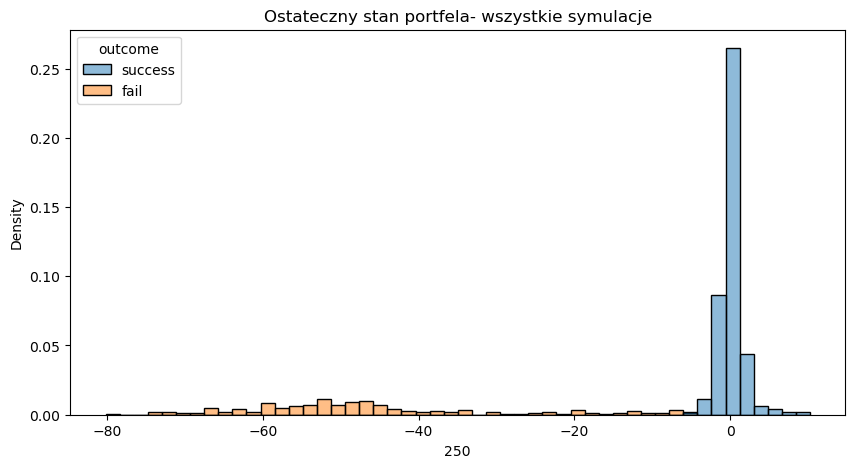

In [69]:
money_time_put_outcome = money_time_put.copy()
money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.5 * V0 else 'fail', axis = 1)
plt.figure(figsize = (10, 5))
sb.histplot(x = money_time_put_outcome[underlying.values_per_year * T], bins = 50, hue = money_time_put_outcome['outcome'], legend = True, stat = 'density').set_title(f'Ostateczny stan portfela- wszystkie symulacje')

In [70]:
money_time_put_outcome[['outcome',underlying.values_per_year * T]].groupby('outcome').describe()

250                                                         \
         count       mean        std        min        25%        50%   
outcome                                                                 
fail     237.0 -46.524097  16.233750 -80.205040 -57.216040 -49.390065   
success  763.0   0.134865   1.541341  -5.256355  -0.560312   0.045303   

                               
               75%        max  
outcome                        
fail    -40.491460  -5.451836  
success   0.661226  10.243281

Text(0.5, 1.0, 'Ostateczny payoff opcji- wszystkie symulacje')

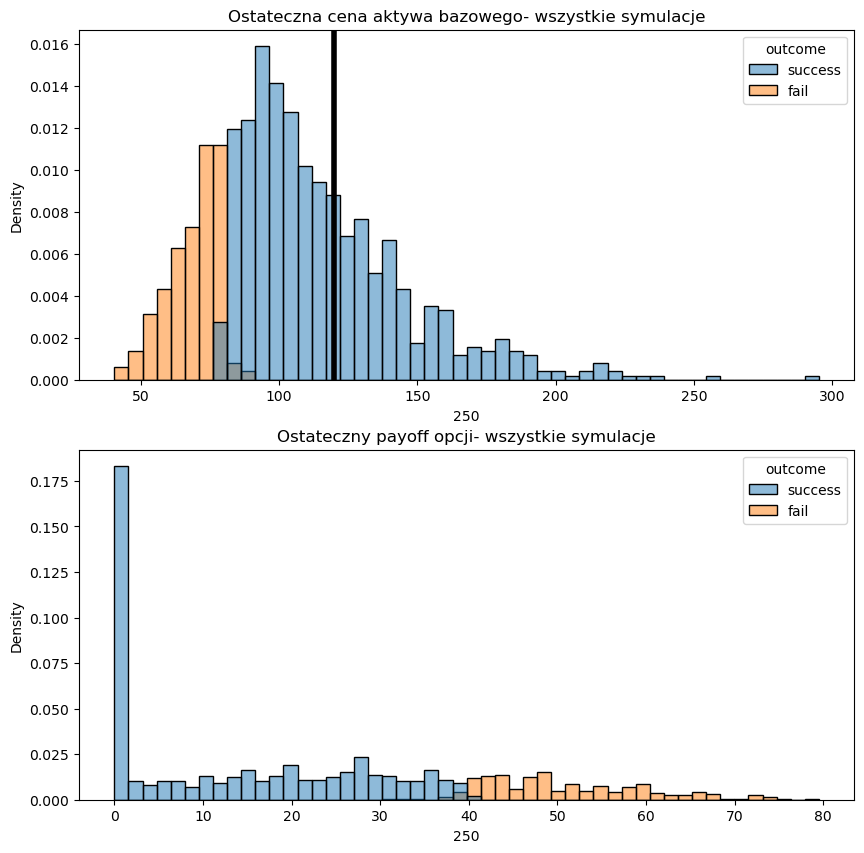

In [71]:
fig, axs = plt.subplots(2,1, figsize = (10, 10))
sb.histplot(ax = axs[0], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczna cena aktywa bazowego- wszystkie symulacje')
axs[0].axvline(K, color = 'black', lw = 4)
sb.histplot(ax = axs[1], x = np.maximum(K - (X0*reality)[underlying.values_per_year * T],0), hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title('Ostateczny payoff opcji- wszystkie symulacje')

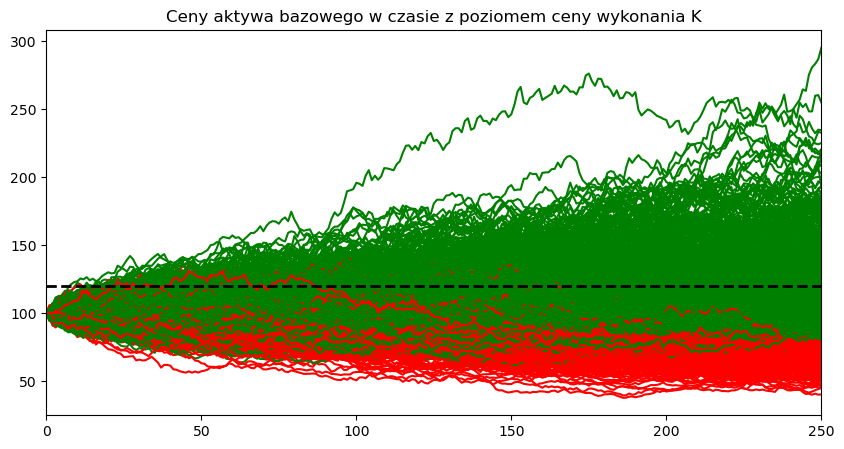

In [72]:
fig, axs = plt.subplots(1, 1, figsize = (10, 5))
(X0*reality).T.plot.line(ax = axs, legend = False, color = money_time_put_outcome.apply(lambda row: 'green' if row['outcome'] == 'success' else 'red', axis = 1), title = 'Ceny aktywa bazowego w czasie z poziomem ceny wykonania K')
axs.set_xlim([0,250])
axs.axhline(y=K, xmin=0, xmax=249, color='black', linestyle='--', lw=2)

## Tests on modified payoff properties

### Vanilla call

In [73]:
K = 80
vanilla_call = Vanilla(underlying, K, T, True)

In [74]:
payoff_func_v0, success_prob, c = payoff_from_v0(vanilla_call, BS_price_call/2, X0)
print(f'Success prob for V0={BS_price_call/2:.2f}: {success_prob:.2f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_call, success_prob, X0)
print(f'Proper V0 for success prob={success_prob:.2f}: {success_V0:.2f}')

Success prob for V0=13.23: 0.81
Proper V0 for success prob=0.81: 13.16


Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

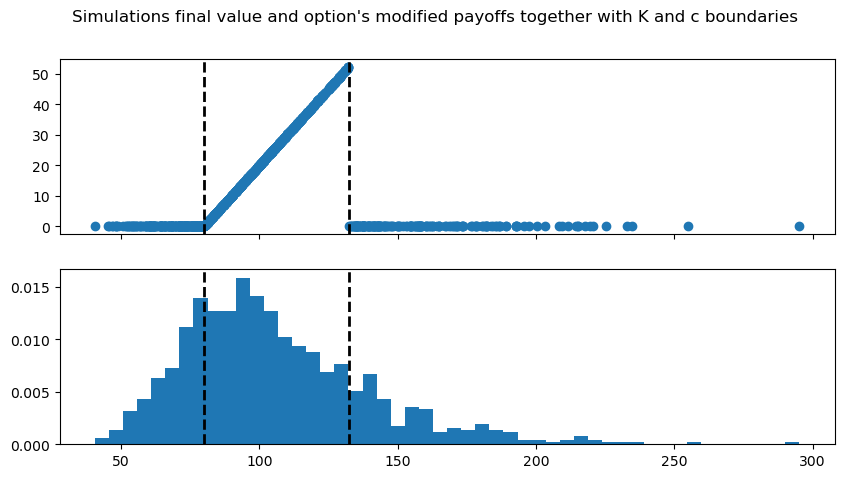

In [75]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)

axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

### Vanilla put

In [76]:
K = 120
vanilla_put = Vanilla(underlying, K, T, False)

In [77]:
payoff_func_v0, success_prob, c = payoff_from_v0(vanilla_put, BS_price_put/2, X0)
print(f'Success prob for V0={BS_price_put/2:.2f}: {success_prob:.2f}')
payoff_func_prob, success_V0, _ = payoff_from_prob(vanilla_put, success_prob, X0)
print(f'Proper V0 for success prob={success_prob}: {success_V0:.2f}')

Success prob for V0=10.53: 0.80
Proper V0 for success prob=0.8015: 10.54


Text(0.5, 0.98, "Simulations final value and option's modified payoffs together with K and c boundaries")

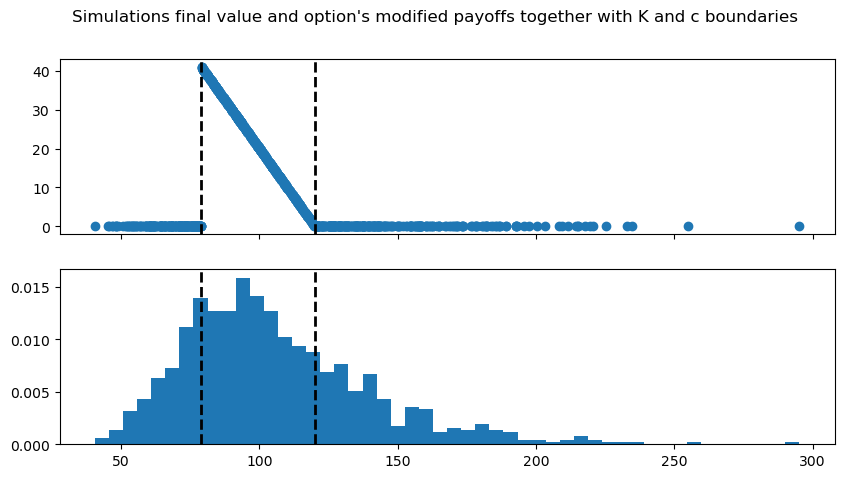

In [78]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (10, 5))
axs[0].scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))
axs[0].axvline(K, color = 'black', linestyle = '--', lw = 2)
axs[0].axvline(c, color = 'black', linestyle = '--', lw = 2)

axs[1].hist(X0*reality.iloc[:,-1], bins = 50, density = True)
axs[1].axvline(K, color = 'black', linestyle = '--', lw = 2)
axs[1].axvline(c, color = 'black', linestyle = '--', lw = 2)
plt.suptitle("Simulations final value and option's modified payoffs together with K and c boundaries")

## Sensivity analysis on $\alpha$ vs success probability

### Vanilla call

4it [00:52, 13.19s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nalpha level vs success probability')

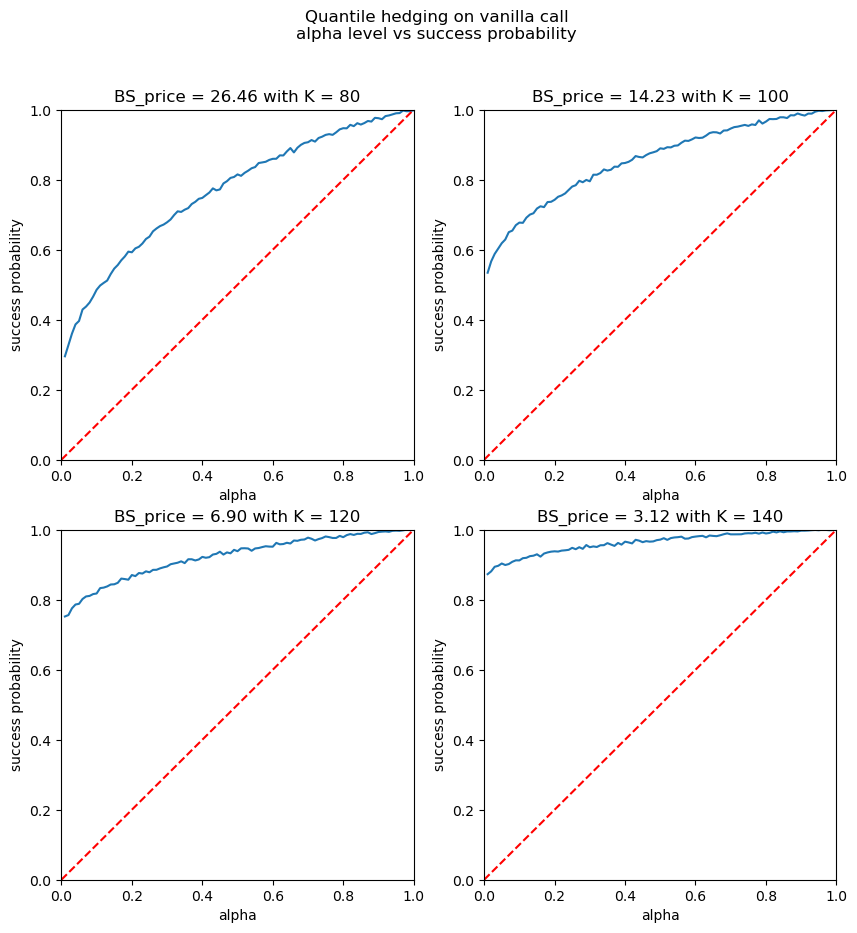

In [13]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    alphas = np.arange(1,101,1)/100
    probs = []
    for a in alphas:
        _, success_prob, _ = payoff_from_v0(vanilla_call, a * BS_price, X0)
        probs.append(success_prob)
    axs[num//2, num%2].plot(alphas, probs)
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', linestyle='--')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('success probability')
    axs[num//2, num%2].set_xlim([0,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla call\nalpha level vs success probability')

4it [15:17, 229.48s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla call\nfinal simulation values')

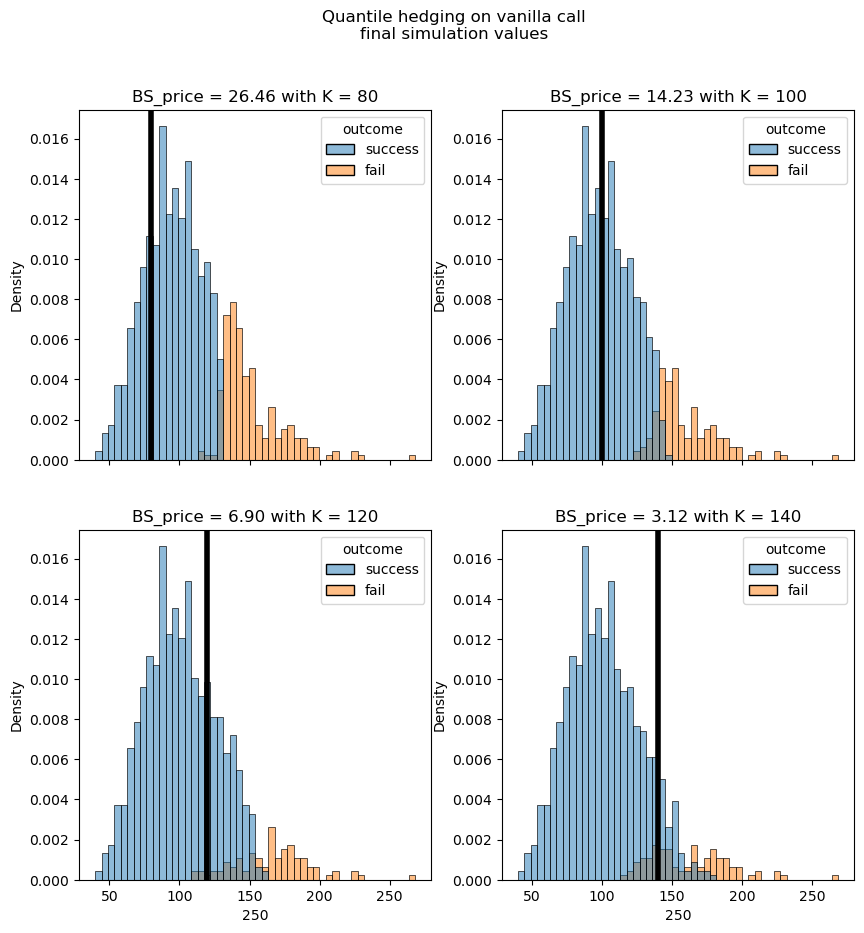

In [26]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_call = Vanilla(underlying, K, T, True)
    BS_price = vanilla_call.get_price(X0, 0)
    V0 = 0.5 * BS_price
    money_time_call = pd.DataFrame(np.zeros(reality.shape))
    delta_time_call = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = V0)
        money, delta, success_prob = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
        money_time_call.loc[i] = money
        delta_time_call.loc[i] = delta
    money_time_call_outcome = money_time_call.copy()
    money_time_call_outcome['outcome'] = money_time_call.apply(lambda row: 'success' if row.iloc[-1] >= - 0.5 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_call_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla call\nfinal simulation values')

### Vanilla put

4it [00:52, 13.11s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nalpha level vs success probability')

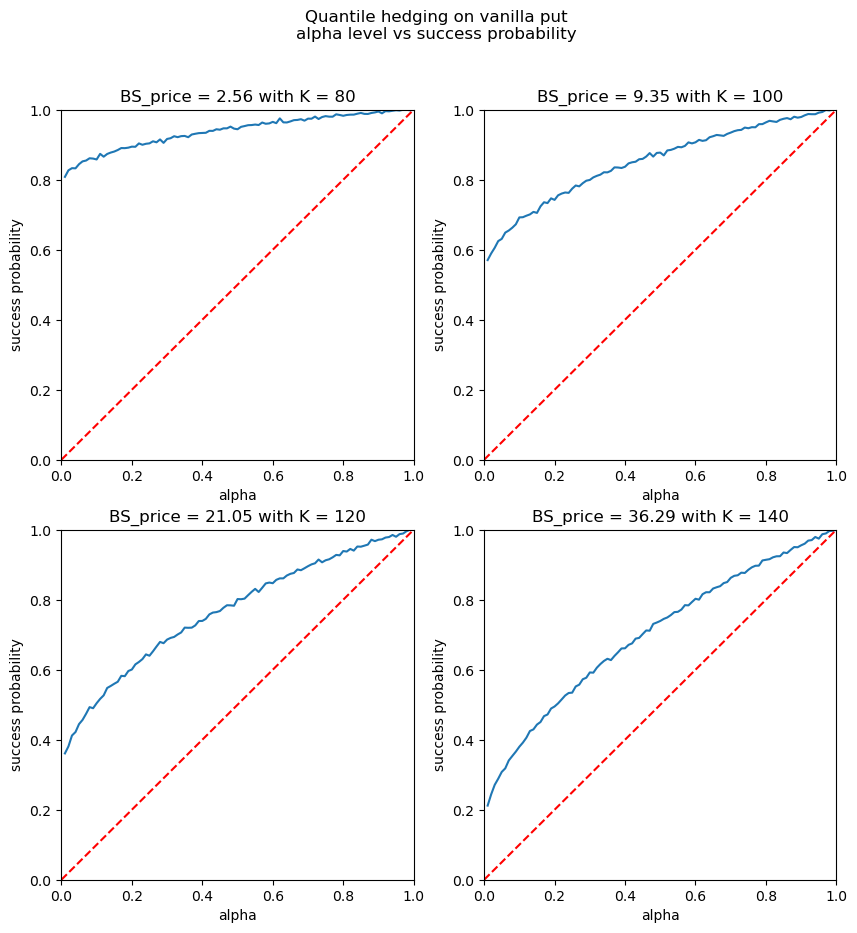

In [23]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    alphas = np.arange(1,101,1)/100
    probs = []
    for a in alphas:
        _, success_prob, _ = payoff_from_v0(vanilla_put, a * BS_price, X0)
        probs.append(success_prob)
    axs[num//2, num%2].plot(alphas, probs)
    axs[num//2, num%2].plot([0,1],[0,1], color = 'red', linestyle='--')
    axs[num//2, num%2].set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].set_xlabel('alpha')
    axs[num//2, num%2].set_ylabel('success probability')
    axs[num//2, num%2].set_xlim([0,1])
    axs[num//2, num%2].set_ylim([0,1])
plt.suptitle('Quantile hedging on vanilla put\nalpha level vs success probability')

4it [14:57, 224.46s/it]


Text(0.5, 0.98, 'Quantile hedging on vanilla put\nfinal simulation values')

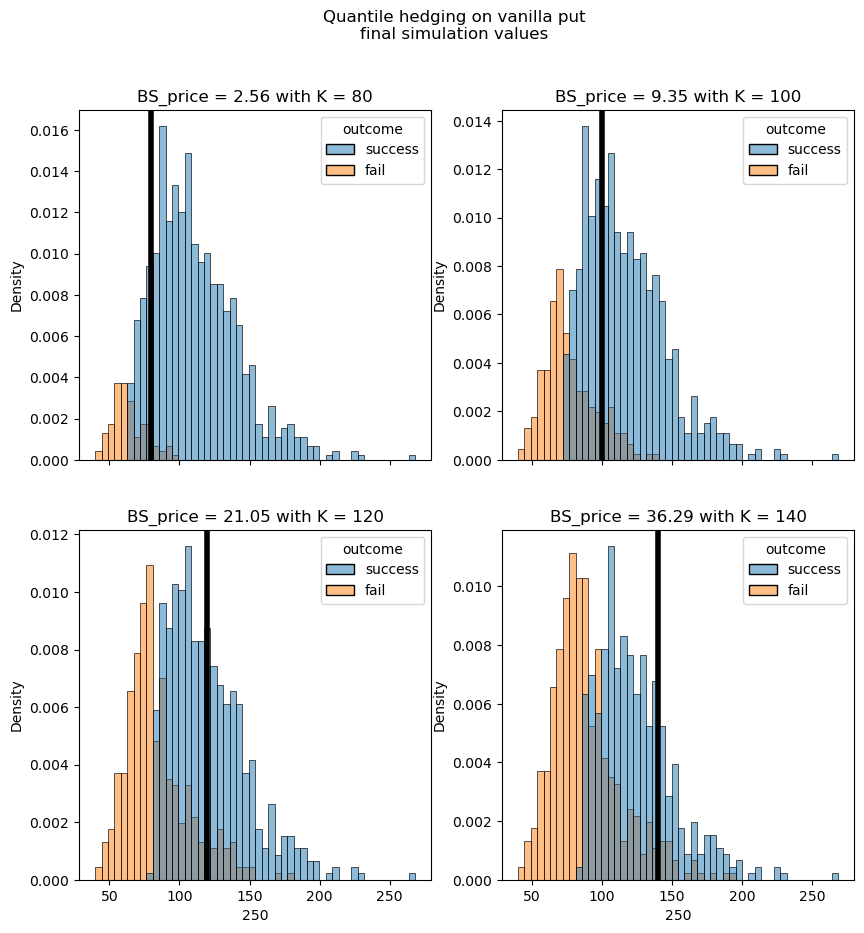

In [27]:
Ks = [80, 100, 120, 140]
fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex = True)
for num, K in tqdm(enumerate(Ks)):
    vanilla_put = Vanilla(underlying, K, T, False)
    BS_price = vanilla_put.get_price(X0, 0)
    money_time_put = pd.DataFrame(np.zeros(reality.shape))
    delta_time_put = pd.DataFrame(np.zeros(reality.shape))
    for i in range(repeat):
        trader = Trader(initial_capital = 0.5 * BS_price)
        money, delta, success_prob = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
        money_time_put.loc[i] = money
        delta_time_put.loc[i] = delta
    money_time_put_outcome = money_time_put.copy()
    money_time_put_outcome['outcome'] = money_time_put.apply(lambda row: 'success' if row.iloc[-1] >= - 0.5 * V0 else 'fail', axis = 1)
    sb.histplot(ax = axs[num//2, num%2], x = (X0*reality)[underlying.values_per_year * T], hue = money_time_put_outcome['outcome'], bins = 50, stat = 'density').set_title(f'BS_price = {BS_price:.2f} with K = {K}')
    axs[num//2, num%2].axvline(K, color = 'black', lw = 4)
plt.suptitle('Quantile hedging on vanilla put\nfinal simulation values')